In [1]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils import graph_tools, qaoaCUDAQ as q, graph_tools
import networkx as nx
import time

cudaq.set_target("nvidia")

In [2]:
# We'll use the graph below to illustrate how QAOA can be used to
# solve a max cut problem

#       v1  0--------------0 v2
#           |              | \
#           |              |  \
#           |              |   \
#           |              |    \
#       v0  0--------------0 v3-- 0 v4
# The max cut solutions are 01011, 10100, 01010, 10101 .

# First we define the graph nodes (i.e., vertices) and edges as lists of integers so that they can be broadcast into
# a cudaq.kernel.

# nodes: List[int] = [0, 1, 2, 3, 4]
# edges = [[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]
# edges_src: List[int] = [edges[i][0] for i in range(len(edges))]
# edges_tgt: List[int] = [edges[i][1] for i in range(len(edges))]

In [ ]:
''' VRAM
25:522
26:778
27:1290
28:2314
29:4362
30:8458
'''

''' Time 20 nodes
NelderMead 57s -> 62@0.0094
COBYLA 35s -> 62@0.0049
SPSA ??
Adam 44s -> 62@0.0169
'''

' Time 20 nodes\nNelderMead\nCOBYLA 13s\nSPSA 23s\nAdam 34s\n'

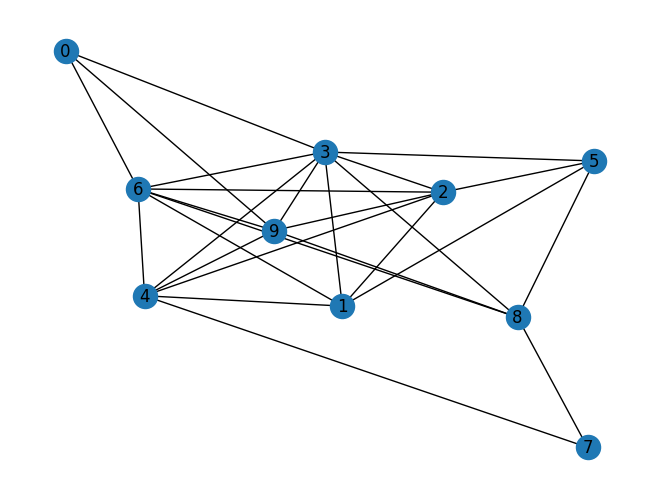

In [47]:
N = 10
is_weighted = False

nodes = list(range(N))
G = nx.Graph.get_random_graph(N, seed=12345)

# Define the number of layers and free parameters (2 per layer).
# Each layer of the QAOA kernel contains 2 parameters.
edges, edges_src, edges_tgt, edge_weights = q.create_qaoa_networkx(G, is_weighted)
nx.draw(G, with_labels=True)

In [48]:
# Problem parameters
# The number of qubits we'll need is the same as the number of vertices in our graph
qubit_count: int = len(nodes)

# We can set the layer count to be any positive integer.  Larger values will create deeper circuits
layer_count: int = 8

# Each layer of the QAOA kernel contains 2 parameters
parameter_count: int = 2 * layer_count


In [52]:
# Specify the optimizer and its initial parameters.
cudaq.set_random_seed(13)
idx = 3

# https://arxiv.org/pdf/2106.08682 for further choices of optimizers
optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam"]
optimizer_name = optimizer_names[idx]
optim_required_grad = ["Adam"]
FIND_GRAD = True if optimizer_name in optim_required_grad else False


np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052]


In [53]:
# Generate the Hamiltonian for our graph
hamiltonian = q.hamiltonian_max_cut(edges_src, edges_tgt, edge_weights)

# print(edges)
# print(type(hamiltonian))
# print(hamiltonian)

# Define the objective, return `<state(params) | H | state(params)>`
# Note that in the `observe` call we list the kernel, the hamiltonian, and then the concrete global variable values of our kernel
# followed by the parameters to be optimized.

In [54]:
cudaq.set_target('nvidia')
# cudaq.set_target('qpp-cpu')

expectations = []

def objective_grad(parameters):
    expectation = cudaq.observe(q.kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         edges_src, edges_tgt, parameters).expectation()
    expectations.append(expectation)

    epsilon = 1e-4
    gradient = []
    for i in range(len(parameters)):
        shifted = parameters[:]
        shifted[i] += epsilon
        shifted_expectation = cudaq.observe(q.kernel_qaoa, hamiltonian, qubit_count,
                                            layer_count, edges_src, edges_tgt,
                                            shifted).expectation()
        grad_i = (shifted_expectation - expectation) / epsilon
        gradient.append(grad_i)
    return expectation, gradient

def objective(parameters):
    expectation = cudaq.observe(q.kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         edges_src, edges_tgt, parameters).expectation()
    expectations.append(expectation)
    return expectation

objective_func = objective_grad if FIND_GRAD else objective

print("Required Gradient = ", FIND_GRAD)
# Optimize!
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

np.save(f"./output/expectations_{optimizer_name}_{len(nodes)}.npy", np.array(expectations))


# Alternatively we can use the vqe call (just comment out the above code and uncomment the code below)
# optimal_expectation, optimal_parameters = cudaq.vqe(
#    kernel=kernel_qaoa,
#    spin_operator=hamiltonian,
#    argument_mapper=lambda parameter_vector: (qubit_count, layer_count, edges_src, edges_tgt, parameter_vector),
#    optimizer=optimizer,
#    parameter_count=parameter_count)

print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least ', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

Required Gradient =  True
optimal_expectation = -17.352606780475234
Therefore, the max cut value is at least  17.352606780475234
optimal_parameters = [0.11737876480183346, -0.28173263134744025, 0.349328274273667, 0.2632376183085726, 0.3301046934819144, -0.052516925198812514, -0.05426083337591809, 0.08781966881765042, -0.0019926202687231883, 0.1231929001613556, -0.3547803862666204, -0.3073434281437472, -0.594121365436747, 0.3238547909399787, -0.022067093745515673, 0.09596826493974221]
Time taken =  4.366539478302002


In [55]:
shots_count = int(1e7)
print(f"Sampling {shots_count} times...")
result = cudaq.sample(q.kernel_qaoa, qubit_count, layer_count, edges_src, edges_tgt, optimal_parameters, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**qubit_count - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(qubit_count)
pred_val = G.evaluate_cut(idx_b2, G.edges.data(data=True), is_weighted)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("Predicted value = ", pred_val)

Sampling 10000000 times...
Finding the best solution...
0001011101 1404062 0.1404062
1110100010 1402563 0.1402563
Predicted value =  19


In [ ]:
assert False

In [58]:
result_final = np.zeros(2**qubit_count)
for i in result:
    result_final[int(i, 2)] = result[i]

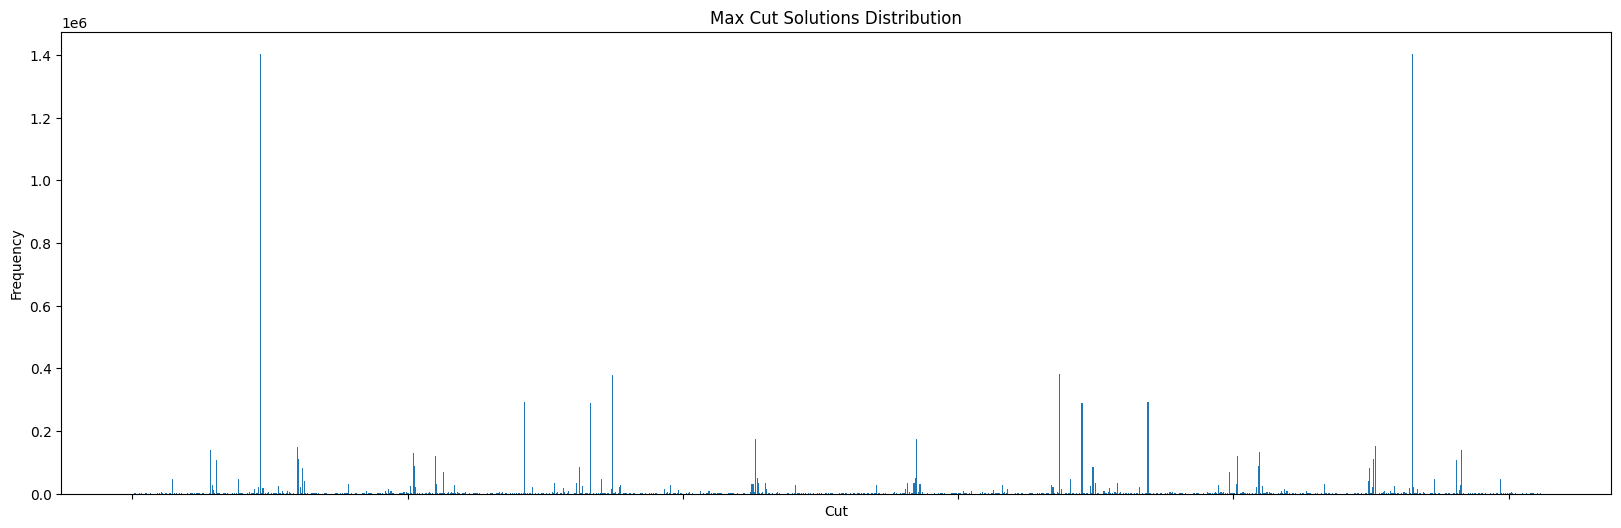

In [59]:
# plt
plt.figure(figsize=(20, 6))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**qubit_count), result_final)
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Max Cut Solutions Distribution')
plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
plt.xticks(visible=False)
plt.show()

Loading expectations from Nelder-Mead
Loading expectations from COBYLA
Loading expectations from SPSA
Loading expectations from Adam


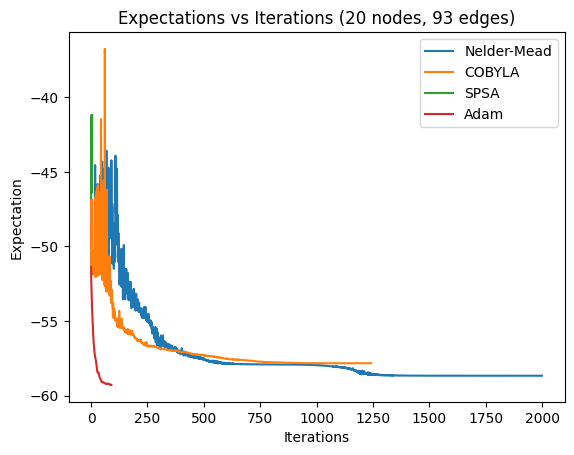

In [ ]:
N_nodes = len(nodes)

plt.Figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output/expectations_{optimizer_names[i]}_{N_nodes}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output/expectations_{optimizer_names[i]}_{N_nodes}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({N_nodes} nodes, {len(edges)} edges)')
plt.legend()
plt.show()